<a href="https://colab.research.google.com/github/RemyLpr/defi_ia/blob/main/analyse_explo/test_set_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import des librairies

In [4]:
!pip install fitter
!pip install scikit-learn==1.1.2
!pip install scipy==1.9.1
!pip install missingpy==0.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 43.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.1
    Uninstalling scikit-learn-1.2.1:
      Successfully uninstalled scikit-learn-1.2.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 21.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from fitter import Fitter, get_common_distributions, get_distributions
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
from sklearn.impute import KNNImputer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import operator
from scipy.stats import chisquare

# Chargement des données

In [2]:
df = pd.read_csv("test_set.csv")
df_req = df.drop_duplicates(subset=['order_requests'])

# Prévisualisation

In [ ]:
df

,index,order_requests,city,date,language,mobile,avatar_id,hotel_id,stock
0,0,1,vilnius,21,romanian,0,1,161,46
1,1,1,vilnius,21,romanian,0,1,187,32
2,2,1,vilnius,21,romanian,0,1,279,12
3,3,1,vilnius,21,romanian,0,1,395,10
4,4,1,vilnius,21,romanian,0,1,488,42
...,...,...,...,...,...,...,...,...,...
6639,6639,843,rome,5,irish,0,794,987,1
6640,6640,844,vienna,1,irish,1,794,26,1
6641,6641,844,vienna,1,irish,1,794,263,0
6642,6642,844,vienna,1,irish,1,794,456,0


# Etude des villes

Premièrement nous allons afficher la répartition des villes dans le dataset de test afin de vérifier si elles sont toutes présentes et de manière équitable.

In [ ]:
df["city"].value_counts()

amsterdam     1134
paris         1125
madrid        1094
copenhagen     723
rome           721
vilnius        609
vienna         568
sofia          374
valletta       296
Name: city, dtype: int64

Les villes sont effectivement toutes bien présentes mais de manière très déséquilibrée. Ce déséquilibre pourrait être retrouvé dans l'ensemble des données, ou pas. Pour avoir une idée de la réponse je vais utiliser des métadonnées associées aux villes qui pourraient expliquer le nombre d'hotêls que l'API renvoie pour celles-ci.

Dans un premier temps je vais vérifier si la répartition vue ci-dessus correspond à la taille des villes étudiées (en terme de nombre d'habitants).
Les données sont tirées du site : https://www.populationdata.net/palmares/villes/europe/

In [ ]:
population_data = {"amsterdam" : 2480394, "paris" : 13114718, "madrid" : 6475872, "copenhagen" : 2931445, "rome" : 4340474, "vilnius" : 673921, "vienna" : 2717459, "sofia" : 1681592, "valletta" : 408750}

Ensuite je suis allé extraire le nombre de recherches Google des termes "hotel" plus nom de la ville. J'ai stocké le nombre de résultats de la requête dans une liste (ordre = same que renvoyé par df["city"]).

In [ ]:
nb_url = [258, 705, 328, 69.5, 545, 11.8, 191, 225, 7.47] # unité = 10**6
# chiffres obtenus sur google.com langue = anglais US

J'ai également été sur le site https://www.booking.com/ et récupéré le nombre d'hôtel renvoyé pour une requête dans chaque ville (pas de dates et résa pour 2 adultes).

In [ ]:
data_booking = [1061, 4980, 3344, 475, 9029, 651, 2287, 971, 235]

Des données sur les pays peuvent également être retenues comme le PIB par habitant (à voir si c'est également utilisable pour la feature language).

In [ ]:
PIB = [48424, 38210, 26239, 58586, 31512, 18072, 45091, 8294, 27738]

In [ ]:
l = list(df["city"].value_counts())
df_city = pd.DataFrame(population_data.items(), columns=['city', 'nb_hab'])
df_city["nb_url"] = nb_url
df_city["booking"] = data_booking
df_city["PIB"] = PIB
df_city["nb_val"] = l

In [ ]:
df_city

,city,nb_hab,nb_url,booking,PIB,nb_val
0,amsterdam,2480394,258.00,1061,48424,1134
1,paris,13114718,705.00,4980,38210,1125
2,madrid,6475872,328.00,3344,26239,1094
3,copenhagen,2931445,69.50,475,58586,723
4,rome,4340474,545.00,9029,31512,721
5,vilnius,673921,11.80,651,18072,609
6,vienna,2717459,191.00,2287,45091,568
7,sofia,1681592,225.00,971,8294,374
8,valletta,408750,7.47,235,27738,296


Toutes ces features pourront également être conservées pour aider à l'entraînement de notre modèle plus tard dans le projet.

Regardons maintenant la distribution des villes par rapport au nombre de requêtes (et non le nombre d'hôtels).

In [ ]:
df_req["city"].value_counts()

paris         99
madrid        98
vilnius       96
sofia         95
amsterdam     94
vienna        93
valletta      92
copenhagen    89
rome          88
Name: city, dtype: int64

Cette distribution semble suivre une loi uniforme. Nous allons tester cette hypothèse à l'aide d'un test du chi2 d'une loi uniforme.

In [ ]:
city_counts = list(df_req["city"].value_counts())
chisquare(city_counts)

Power_divergenceResult(statistic=1.1895734597156398, pvalue=0.9967438605173313)

La pvaleur du test de chi2 est très proche de 1, on ne peut donc pas rejeter l'hypothèse d'une distribution uniforme des villes dans le dataset de test. Les légères différences observées sont donc certainement dues au hasard.

# Etude de la date

Ici nous allons étudier la distribution des dates dans le jeu de données de test, afin de voir si il y a un pic de réservation et quand se trouve-t-il.

(array([58., 58., 60., 56., 56., 59., 57.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., 34., 34., 33., 34., 29., 33., 33.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 28., 33., 30., 30., 33.,
        29., 27.]),
 array([ 0.        ,  0.97560976,  1.95121951,  2.92682927,  3.90243902,
         4.87804878,  5.85365854,  6.82926829,  7.80487805,  8.7804878 ,
         9.75609756, 10.73170732, 11.70731707, 12.68292683, 13.65853659,
        14.63414634, 15.6097561 , 16.58536585, 17.56097561, 18.53658537,
        19.51219512, 20.48780488, 21.46341463, 22.43902439, 23.41463415,
        24.3902439 , 25.36585366, 26.34146341, 27.31707317, 28.29268293,
        29.26829268, 30.24390244, 31.2195122 , 32.19512195, 33.17073171,
        34.14634146, 35.12195122, 36.09756098, 37.07317073, 38.04878049,
        39.02439024, 40.        ]),
 <a list of 41 Patch objects>)

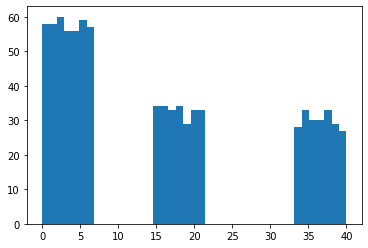

In [ ]:
plt.hist(df_req["date"], bins= 41) # attention au nombre de bins

En observant la distribution des valeurs il semble clair que celle-ci que des intervalles de dates ont été volontairement retirés du set de test. Nous allons donc tenter d'approximer la distribution de ces valeurs estimant le nombre de réservations à partir de la date dans le but de l'utiliser pour notre stratégie de reqûetage de l'API.

Fitting 5 distributions: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,0.240544,860.613826,-6869.361372,inf,0.269223,1.622692e-54
burr,0.246205,888.264527,-6842.989746,inf,0.274488,1.089058e-56
beta,0.254240,829.463092,-6815.887810,inf,0.302072,8.128871e-69
lognorm,0.268760,1155.484096,-6775.749245,inf,0.387878,8.006454e-115
norm,0.279109,793.762607,-6750.596035,inf,0.230904,4.795906e-40


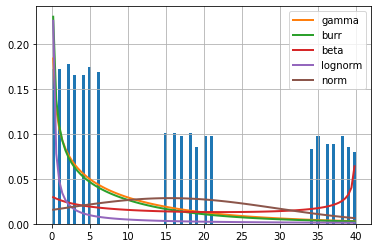

In [ ]:
dates = df_req["date"].values
f = Fitter(dates, distributions=['gamma', 'lognorm', "beta", "burr", "norm"])
f.fit()
f.summary()

On peut voir ici que les valeurs manquantes nous empêchent de prédire correctement la distribution des données. On va donc tester différentes techniques de data imputation pour régler ce problème.

In [ ]:
nb_occ_date = df_req["date"].value_counts().rename_axis('date').reset_index(name='nb_occ').sort_values(by = ["date"])
# ajout des NaN dans le dataframe
for d in range(0,45):
  if d not in nb_occ_date["date"].values:
    nb_occ_date = nb_occ_date.append({'date':d, 'nb_occ':np.nan}, ignore_index=True)
nb_occ_date = nb_occ_date.sort_values(by = ["date"])

Nous allons effectuer une imputation à l'aide de l'algorithme MissForest.

In [ ]:
# data imputation
imp = MissForest()
nb_occ_date_mf = imp.fit_transform(nb_occ_date)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


Affichons maintenant le nombre d'occurrences de chaque date après l'imputation.

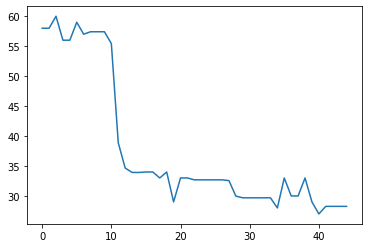

In [ ]:
df_filled_mf = pd.DataFrame(nb_occ_date_mf, columns = ["date", "nb_occ"])
plt.plot(df_filled_mf["date"], df_filled_mf["nb_occ"])

Nous allons maintenant utiliser l'algorithme KNNImputer et comparer les résultats.

In [ ]:
imputer = KNNImputer(n_neighbors=8)
nb_occ_date_knn = imputer.fit_transform(nb_occ_date)

In [ ]:
df_filled_knn = pd.DataFrame(nb_occ_date_knn, columns = ["date", "nb_occ"])
df_knn = df_filled_knn.copy()
# créer dataframe avec nb_occ fois chaque date
for index, row in df_filled_knn.iterrows():
  for i in range(1, int(row["nb_occ"])): # on commence à 1 car on a déjà 1 fois chaque valeur dans le df
    df_knn = df_knn.append({'date':row["date"], 'nb_occ':row["nb_occ"]}, ignore_index = True)
#plt.plot(df_filled_knn["date"], df_filled_knn["nb_occ"])
df_knn['nb_occ'] = df_knn['nb_occ'].astype(int)

(array([58., 58., 60., 56., 56., 59., 57., 54., 51., 51., 48., 42., 39.,
        35., 35., 34., 34., 33., 34., 29., 33., 33., 32., 32., 32., 32.,
        31., 31., 31., 31., 31., 30., 30., 30., 28., 33., 30., 30., 33.,
        29., 27., 30., 30., 30., 30.]),
 array([ 0.        ,  0.97777778,  1.95555556,  2.93333333,  3.91111111,
         4.88888889,  5.86666667,  6.84444444,  7.82222222,  8.8       ,
         9.77777778, 10.75555556, 11.73333333, 12.71111111, 13.68888889,
        14.66666667, 15.64444444, 16.62222222, 17.6       , 18.57777778,
        19.55555556, 20.53333333, 21.51111111, 22.48888889, 23.46666667,
        24.44444444, 25.42222222, 26.4       , 27.37777778, 28.35555556,
        29.33333333, 30.31111111, 31.28888889, 32.26666667, 33.24444444,
        34.22222222, 35.2       , 36.17777778, 37.15555556, 38.13333333,
        39.11111111, 40.08888889, 41.06666667, 42.04444444, 43.02222222,
        44.        ]),
 <a list of 45 Patch objects>)

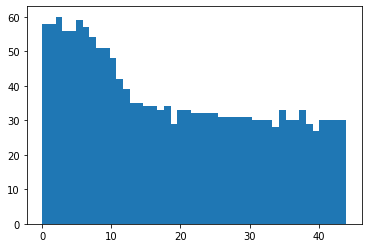

In [ ]:
plt.hist(df_knn["date"], bins= 45) # attention au nombre de bins

Les résultats semblent s'approcher bien plus d'une distribution réaliste des valeurs, on va maintenant pouvoir approximer cette distribution de valeurs.

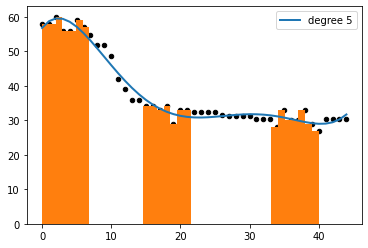

In [ ]:
X = df_filled_knn["date"].values.reshape(-1, 1)
y = df_filled_knn["nb_occ"].values.reshape(-1, 1)
models = []
for count, degree in enumerate([5]): # degré à chosir
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=0.001))
    model.fit(X, y)
    models.append(model)
    y_pred = model.predict(X)
    plt.plot(X, y_pred, linewidth=2, label='degree %d' % degree)
plt.legend(loc='upper right')
plt.scatter(X, y, s=20, marker='o', label='training points', c = "black")
plt.hist(df_req["date"], bins= 41) # attention au nombre de bins
plt.show()

TO DO : Essayer de trouver sur internet un graphe de l'évolution des prix des chambres d'hôtel en fonction de la date de réservation et comparer à ce qu'on a obtenu ici.

# Etude du language

Tout d'abordd récupérons le dataframe avec une ligne par requête et non par hôtel retourné.

In [ ]:
df_lang = df.drop_duplicates(subset=['order_requests'])
df_lang["language"].value_counts()

hungarian        120
finnish           59
austrian          58
slovakian         56
romanian          53
swedish           52
bulgarian         52
estonian          49
danish            46
maltese           25
irish             23
slovene           22
spanish           21
greek             20
belgian           20
french            18
dutch             16
latvian           16
polish            15
italian           15
lithuanian        14
czech             14
cypriot           13
luxembourgish     13
croatian          12
german            12
portuguese        10
Name: language, dtype: int64

La distribution des langues par requête semble être répartie en 3 classes. Il serait intéressant d'oberser les cardinalités des tuples (city, language) pour voir si il y a des choses à remarquer de ce côté là.

In [ ]:
dico_tuple = {}
for index, row in df_lang.iterrows():
  crt_tuple = (row["city"], row["language"])
  if crt_tuple in dico_tuple.keys():
    dico_tuple[crt_tuple] +=1
  else:
    dico_tuple[crt_tuple] = 1
list_tuple= sorted(dico_tuple.items(), key=operator.itemgetter(1)) 
sort_dict_tuple = dict(list_tuple)
print(sort_dict_tuple)

{('paris', 'greek'): 1, ('paris', 'polish'): 1, ('amsterdam', 'belgian'): 1, ('madrid', 'lithuanian'): 1, ('vilnius', 'lithuanian'): 1, ('amsterdam', 'polish'): 1, ('amsterdam', 'italian'): 1, ('valletta', 'italian'): 1, ('paris', 'german'): 1, ('vilnius', 'french'): 1, ('vilnius', 'greek'): 1, ('sofia', 'greek'): 1, ('sofia', 'maltese'): 1, ('rome', 'czech'): 1, ('valletta', 'croatian'): 1, ('paris', 'czech'): 1, ('madrid', 'latvian'): 1, ('rome', 'portuguese'): 1, ('vilnius', 'belgian'): 1, ('amsterdam', 'luxembourgish'): 1, ('vilnius', 'german'): 1, ('sofia', 'german'): 1, ('rome', 'french'): 1, ('vilnius', 'slovene'): 1, ('amsterdam', 'german'): 1, ('vienna', 'portuguese'): 1, ('vienna', 'french'): 1, ('vienna', 'spanish'): 1, ('valletta', 'dutch'): 1, ('sofia', 'luxembourgish'): 1, ('vilnius', 'dutch'): 1, ('copenhagen', 'portuguese'): 1, ('vienna', 'maltese'): 1, ('valletta', 'lithuanian'): 1, ('vilnius', 'italian'): 1, ('vilnius', 'portuguese'): 1, ('rome', 'lithuanian'): 1, ('a

In [22]:
def distrib_lang(df):
  plt.figure(figsize=(20,12))
  plt.title("Number of requests per language", fontsize=25)
  plt.pie(df["language"].value_counts().values.tolist(), labels = df["language"].value_counts().index.tolist(), textprops={'fontsize': 15})
  return

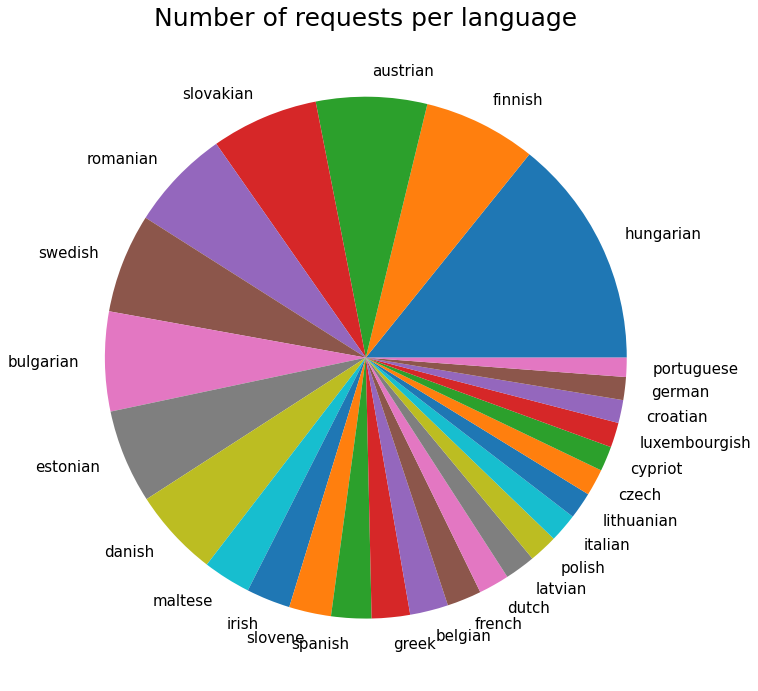

In [23]:
distrib_lang(df_req)

Pas grand chose d'intéressant ici, observons maintenant la distribution des langues par ville pour voir si c'est similaire ou très différent.

In [ ]:
def distrib_lang_per_city(df, city):
  df_per_request = df.drop_duplicates(subset=['order_requests'])
  df_city = df_per_request[df_per_request["city"] == city]
  plt.figure(figsize=(20,12))
  plt.hist(df_city["language"], bins = df_city["language"].nunique())
  return

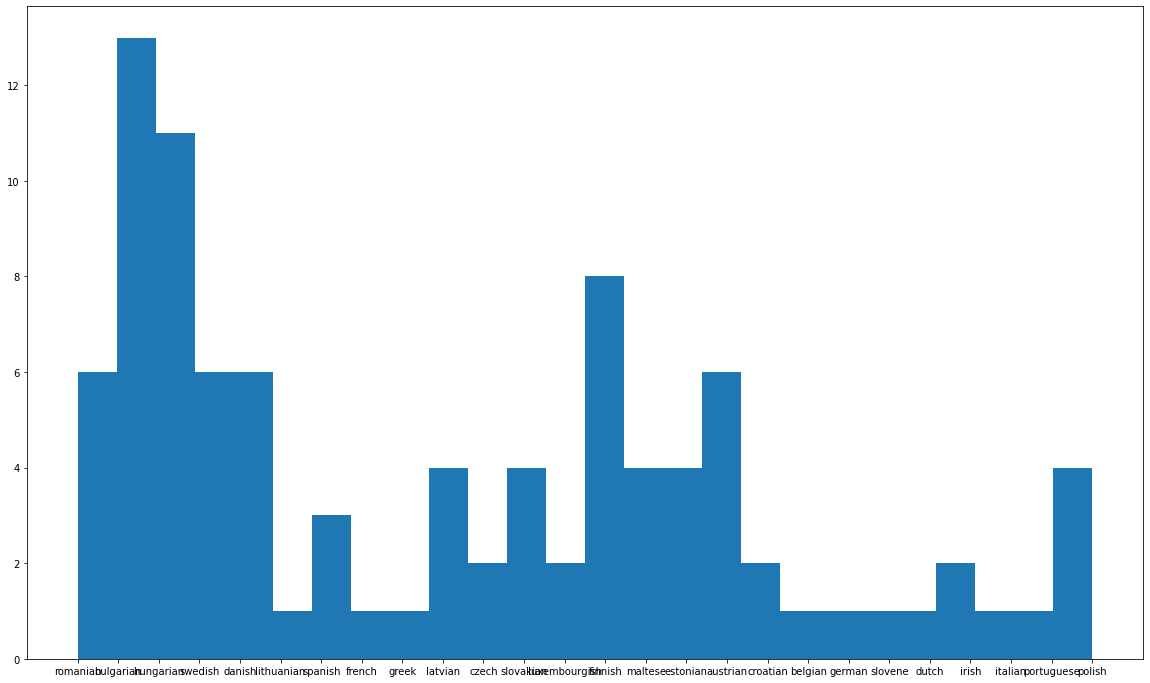

In [ ]:
distrib_lang_per_city(df, "vilnius")

Caractérisons maintenant les 3 groupes de langue du test set (par ordre décroissant de fréquence). <br>
G1 = ["hungarian"] <br> mean_G1 = 120 req <br>
G2 = ["finnish", "austrian", "slovakian", "romanian", "swedish", "bulgarian", "estonian", "danish"] <br> mean_G2 = 53.125 <br>
G3 = ["maltese", "irish", "slovene", "spanish", "greek", "belgian", "french", "dutch", "latvian", "polish", "italian", "lithuanian", "czech", "cypriot", "luxembourgish", "croatian", "german", "portuguese"] <br> mean_G3 = 16.61 <br>
**Ces groupes seront peut-être utilisables plus tard donc autant les garder en mémoire.**

# Etude du support (pc/phone)

Nous allons séparer le dataframe en 2 en fonction du support et étudier les différences de distribution des autres variables en fonction de celle-ci.

In [ ]:
df_cp = df_req[df_req["mobile"] == 0] # computer
df_ph = df_req[df_req["mobile"] == 1] # phone
print(len(df_cp))
print(len(df_ph))
print(df_cp["date"].mean(), "date mean cp")
print(df_ph["date"].mean(), "date mean ph")
print(df_cp["stock"].mean(), "stock mean cp")
print(df_ph["stock"].mean(), "stock mean ph")

453
391
16.973509933774835 date mean cp
13.838874680306905 date mean ph
31.69757174392936 stock mean cp
23.84910485933504 stock mean ph


Il pourrait être très intéressant de mener une **Analyse Factorielle ici (à voir laquelle) sur RStudio** afin de pouvoir identifier des liens entres les variables (qui sont quantitatives et qualitatives) du jeu de données. <br>
Par exemple on peut voir ici, qu'en moyenne, dans le jeu de données de test les recherches par téléphone sont faites à des dates plus proches de la date de réservation (ce qui paraît assez intuitif) que les recherches faites sur ordinateur.

(array([31., 31., 32., 27., 29., 27., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., 11., 10., 17., 19., 16., 17., 19.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4., 13.,  8., 10., 13.,
        18.,  9.]),
 array([ 0.        ,  0.97560976,  1.95121951,  2.92682927,  3.90243902,
         4.87804878,  5.85365854,  6.82926829,  7.80487805,  8.7804878 ,
         9.75609756, 10.73170732, 11.70731707, 12.68292683, 13.65853659,
        14.63414634, 15.6097561 , 16.58536585, 17.56097561, 18.53658537,
        19.51219512, 20.48780488, 21.46341463, 22.43902439, 23.41463415,
        24.3902439 , 25.36585366, 26.34146341, 27.31707317, 28.29268293,
        29.26829268, 30.24390244, 31.2195122 , 32.19512195, 33.17073171,
        34.14634146, 35.12195122, 36.09756098, 37.07317073, 38.04878049,
        39.02439024, 40.        ]),
 <a list of 41 Patch objects>)

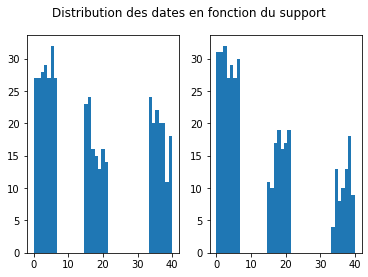

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Distribution des dates en fonction du support')
ax1.hist(df_cp["date"], bins= 41) # computer
ax2.hist(df_ph["date"], bins= 41) # phone

Comme avant pour la distribution des dates, on va imputer les valeurs manquantes pour pouvoir estimer la distribution des dates pour chaque groupe (computer/phone).

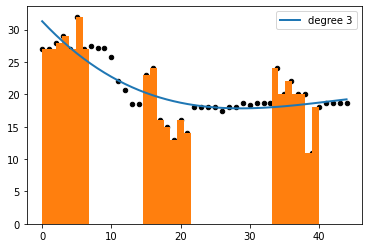

In [ ]:
# computer
nb_occ_date = df_cp["date"].value_counts().rename_axis('date').reset_index(name='nb_occ').sort_values(by = ["date"])
for d in range(0,45):
  if d not in nb_occ_date["date"].values:
    nb_occ_date = nb_occ_date.append({'date':d, 'nb_occ':np.nan}, ignore_index=True)
nb_occ_date = nb_occ_date.sort_values(by = ["date"])
imputer = KNNImputer(n_neighbors=8)
nb_occ_date_knn = imputer.fit_transform(nb_occ_date)
df_filled_knn = pd.DataFrame(nb_occ_date_knn, columns = ["date", "nb_occ"])
df_knn = df_filled_knn.copy()
# créer dataframe avec nb_occ fois chaque date
for index, row in df_filled_knn.iterrows():
  for i in range(1, int(row["nb_occ"])): # on commence à 1 car on a déjà 1 fois chaque valeur dans le df
    df_knn = df_knn.append({'date':row["date"], 'nb_occ':row["nb_occ"]}, ignore_index = True)
df_knn['nb_occ'] = df_knn['nb_occ'].astype(int)
X = df_filled_knn["date"].values.reshape(-1, 1)
y = df_filled_knn["nb_occ"].values.reshape(-1, 1)
models = []
for count, degree in enumerate([3]): # degré à chosir
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=0.001))
    model.fit(X, y)
    models.append(model)
    y_pred_cp = model.predict(X)
    plt.plot(X, y_pred_cp, linewidth=2, label='degree %d' % degree)
plt.legend(loc='upper right')
plt.scatter(X, y, s=20, marker='o', label='training points', c = "black")
plt.hist(df_cp["date"], bins= 41) # attention au nombre de bins
plt.show()

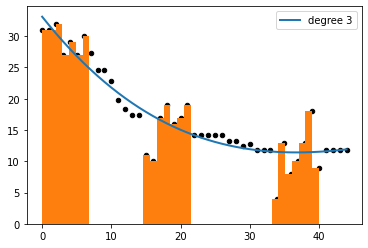

In [ ]:
# phone
nb_occ_date = df_ph["date"].value_counts().rename_axis('date').reset_index(name='nb_occ').sort_values(by = ["date"])
for d in range(0,45):
  if d not in nb_occ_date["date"].values:
    nb_occ_date = nb_occ_date.append({'date':d, 'nb_occ':np.nan}, ignore_index=True)
nb_occ_date = nb_occ_date.sort_values(by = ["date"])
imputer = KNNImputer(n_neighbors=8)
nb_occ_date_knn = imputer.fit_transform(nb_occ_date)
df_filled_knn = pd.DataFrame(nb_occ_date_knn, columns = ["date", "nb_occ"])
df_knn = df_filled_knn.copy()
# créer dataframe avec nb_occ fois chaque date
for index, row in df_filled_knn.iterrows():
  for i in range(1, int(row["nb_occ"])): # on commence à 1 car on a déjà 1 fois chaque valeur dans le df
    df_knn = df_knn.append({'date':row["date"], 'nb_occ':row["nb_occ"]}, ignore_index = True)
df_knn['nb_occ'] = df_knn['nb_occ'].astype(int)
X = df_filled_knn["date"].values.reshape(-1, 1)
y = df_filled_knn["nb_occ"].values.reshape(-1, 1)
models = []
for count, degree in enumerate([3]): # degré à chosir
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=0.001))
    model.fit(X, y)
    models.append(model)
    y_pred_ph = model.predict(X)
    plt.plot(X, y_pred_ph, linewidth=2, label='degree %d' % degree)
plt.legend(loc='upper right')
plt.scatter(X, y, s=20, marker='o', label='training points', c = "black")
plt.hist(df_ph["date"], bins= 41) # attention au nombre de bins
plt.show()

On voit clairement que les distributions des dates sont différentes selon la modalité de la variable support. Afin d'établir au mieux notre stratégie de requêtage, nous allons maintenant vérifier que la distribution de cette variable soit elle-même uniforme.

In [ ]:
support_counts = list(df_req["mobile"].value_counts())
chisquare(support_counts)

Power_divergenceResult(statistic=4.5545023696682465, pvalue=0.03283230348154647)

La pvaleur est < à 0.05, la distribution des valeurs ne semble pas uniforme pour la variable support. Nous allons donc considérer la distribution empirique comme si c'était la théorique. (pas sûr qu'on doive faire ça ptdr)

In [ ]:
computer_part = support_counts[0]/sum(support_counts)
print("Part des ordinateurs : ", computer_part)
mobile_part = support_counts[1]/sum(support_counts)
print("Part des téléphones : ", mobile_part)

Part des ordinateurs :  0.5367298578199052
Part des téléphones :  0.46327014218009477


Pour approximer et avoir un code plus lisible (et une démarche plus compréhensible), nous allons approximer ces valeurs par 7/13 et 6/13. Vérifions maintenant que la distribution se fait bien selon ces fréquences.

In [ ]:
support_counts = list(df_req["mobile"].value_counts())
chisquare(support_counts, f_exp = [7/13*len(df_req), 6/13*len(df_req)])

Power_divergenceResult(statistic=0.010183931392462075, pvalue=0.9196175652422924)

Le choix de ces valeurs semble être le bon, maintenant nous savons qu'au final il faudra obtenir 7/13 de mobile = computer et 6/13 de mobile = phone. Sauf que la distribution de ces modalités diffère selon la date, il nous reste donc à inférer cette distribution.

In [ ]:
cp_prop_list = [] # proba que mobile = 0 à une date donnée, A CONSERVER
for i in range(0, len(y_pred_cp)):
  cp_prop_list.append(y_pred_cp[i][0]/(y_pred_cp[i][0]+y_pred_ph[i][0])) # j'ai rajoute les "[0]" car c'est des listes d'array à la base (format très bizarre)

In [ ]:
# transformation du format des listes de prédiciton, le format était chiant
pred = []
for x in y_pred: # faut exécuter la partie date avant
  pred.append(x[0])
pred_cp = []
for x in y_pred_cp:
  pred_cp.append(x[0])
pred_ph = []
for x in y_pred_ph:
  pred_ph.append(x[0])

In [ ]:
cp_prop = 0
for rank, prop in enumerate(cp_prop_list):
  cp_prop += (pred[rank]/sum(pred)) * prop
cp_prop

0.5487293835465759

On voit que la proportion de computers a augmenté. En fait ceci est logique car toutes les dates ne se trouvaient pas dans le jeu de donénes de test et lorsque l'on a imputé les nouvelles valeurs on a forcément au moins légèrement altéré la distribution des modalités.

Au final, on peut calculer la part de requête à effectuer pour chaque date afin de suivre la distribution ci-dessus.

In [ ]:
coeffs_date = [] # proba que mobile = 0 à une date donnée, A CONSERVER
for i in range(0, len(pred)):
  coeffs_date.append(pred[i]/sum(pred))
coeffs_date

[0.03334651431326377,
 0.03449209367880525,
 0.034968926862940494,
 0.03489983306477761,
 0.03439534793684481,
 0.033554283787054835,
 0.03246428978066955,
 0.031202412142264352,
 0.02983565435769277,
 0.028421537376050913,
 0.02700865981164197,
 0.025637258145940763,
 0.024339766929558183,
 0.023141378984205752,
 0.022060605604660107,
 0.02110983676072749,
 0.02029590129920828,
 0.019620627145861463,
 0.019081401507369193,
 0.018671731073301213,
 0.018381802218079387,
 0.01819904120294244,
 0.018108674377909847,
 0.01809428838374703,
 0.01813839035392958,
 0.018222968116607594,
 0.018330050396570482,
 0.01844226701721105,
 0.018543409102490745,
 0.018618989278903254,
 0.018656801877439646,
 0.01864748313555261,
 0.018585071399121116,
 0.01846756732441488,
 0.018297494080058506,
 0.01808245754899687,
 0.017835706530458125,
 0.017576692941920147,
 0.017331632021073594,
 0.017134062527786948,
 0.017025406946070184,
 0.01705553168604149,
 0.017283307285888918,
 0.017777168613837102,
 0.01

On va maintenant sauvegarder ces coefficients sous la forme d'un csv avec les jours correspondants. Nous pourrons l'utiliser plus tard pour mettre en place la stratégie de requêtage.

In [ ]:
coeffs_date = pd.DataFrame(data = list(zip(list(range(0, 45)), coeffs_date)), columns = ["date", "coeff"])
coeffs_date # ça crée une sorte de double index peut-être qu'on pourrait s'en passer mais osef

,date,coeff
0,0,0.033347
1,1,0.034492
2,2,0.034969
3,3,0.034900
4,4,0.034395
5,5,0.033554
6,6,0.032464
7,7,0.031202
8,8,0.029836
9,9,0.028422


In [ ]:
coeffs_date.to_csv("coeffs_date.csv")

On va faire la même chose pour sauvegarder la probabilité que mobile = 0 par date.

In [ ]:
cp_prop_list = pd.DataFrame(data = list(zip(list(range(0, 45)), cp_prop_list)), columns = ["date", "computer"])
cp_prop_list.to_csv("coeffs_computer.csv")

# Etude de l'utilisation des avatars

Tout d'abord, on remarque dans la partie prévisualisation qu'il y a **quasiment autant d'avatars que des requêtes**. Ceci pourra être utilisé lorsque nous allons requêter le jeu de données d'entraînement. <br>
Observons les avatars étant utilisés plusieurs fois.

In [ ]:
df_req_per_avatar = pd.DataFrame(df_req["avatar_id"].value_counts()) # on compte les req par id d'avatar
df_multiple_req_per_avatar = df_req_per_avatar[df_req_per_avatar["avatar_id"]>1] # on garde les id tq nb req > 1
multiple_req_index_list = df_multiple_req_per_avatar.index # on récupère les index de ces lignes
df_avatar = df[df["avatar_id"].isin(multiple_req_index_list)]
df_avatar.to_csv("df_multique_req_avatar.csv")

Ce serait bien d'analyser ce dataframe (voire de scraper les données associées). On pourrait comparer par exemple l'évolution du prix d'un chambre d'hôtel avec une date mouvante pour le même avatar vs pour 2 avatars différents et faire un test pour voir si la différence est égale. Si on part sur cette méthode pour tout le dataframe, qui correspond à environ 100 requêtes, ça va nous coûter 200 requêtes en tout (car on doit faire avatar diff vs same avatar) et pourrait beaucoup nous aider à comprendre l'influence de ceux-ci. Potentiellement il pourrait être utile de créer des variables comme "a_un_historique" ou autre (cf forum) en rapport avec les avatars.

In [ ]:
df_avatar

,index,order_requests,city,date,language,mobile,avatar_id,hotel_id,stock
0,0,1,vilnius,21,romanian,0,1,161,46
1,1,1,vilnius,21,romanian,0,1,187,32
2,2,1,vilnius,21,romanian,0,1,279,12
3,3,1,vilnius,21,romanian,0,1,395,10
4,4,1,vilnius,21,romanian,0,1,488,42
...,...,...,...,...,...,...,...,...,...
6639,6639,843,rome,5,irish,0,794,987,1
6640,6640,844,vienna,1,irish,1,794,26,1
6641,6641,844,vienna,1,irish,1,794,263,0
6642,6642,844,vienna,1,irish,1,794,456,0


Dans l'hypothèse on on devra rajouter des requêtes multi avatar plus tard, je vais étudier la distribution du nombre de requêtes par avatar dans le test set.

In [ ]:
df_req_per_avatar.value_counts()

avatar_id
1            749
2             17
3             15
4              4
dtype: int64

# Stratégie de requêtage

Bon du coup après toutes ces analyses on peut arriver à une première version de stratégie de requêtage, que je vais expliquer attribut par attribut :

*   city : répartition uniforme, validée par test de chi2
*   date : répartition suivant la distribution estimée par le modèle KNN, voir fichier coeffs_date.csv
*   language : répartition uniforme parce-que je ne sais pas vraiment quoi proposer d'autre (la répartition dans le test set est wtf)
*   mobile : répartition dépendant de la date, inférée de la même manière que celle-ci, voir fichier coeffs_computer.csv
*   avatar : étude pas encore assez poussée dessus, pour l'instant je propose un avatar unique à chaque requête

